---
Vérifier qu'on n'est pas en 3.10.2 (sinon PyTorch ne marchera pas)

---
Vérifier qu'on n'est pas en 3.10.2 (sinon PyTorch ne marchera pas)

In [94]:
import sys
print(sys.version)

3.8.10 (tags/v3.8.10:3d8993a, May  3 2021, 11:48:03) [MSC v.1928 64 bit (AMD64)]


---
Imports - notemment de clubs_gym (https://github.com/fschlatt/clubs_gym)

In [95]:
import gym
import clubs_gym
import time
import random
import numpy as np
import pickle
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import matplotlib.pyplot as plt

---
Liste des environnements disponibles

In [96]:
clubs_gym.ENVS

['LeducTwoPlayer-v0',
 'KuhnTwoPlayer-v0',
 'KuhnThreePlayer-v0',
 'LimitHoldemTwoPlayer-v0',
 'LimitHoldemSixPlayer-v0',
 'LimitHoldemNinePlayer-v0',
 'NoLimitHoldemTwoPlayer-v0',
 'NoLimitHoldemSixPlayer-v0',
 'NoLimitHoldemNinePlayer-v0',
 'NoLimitHoldemBbAnteNinePlayer-v0',
 'PotLimitOmahaTwoPlayer-v0',
 'PotLimitOmahaSixPlayer-v0',
 'PotLimitOmahaNinePlayer-v0',
 'ShortDeckTwoPlayer-v0',
 'ShortDeckSixPlayer-v0',
 'ShortDeckNinePlayer-v0']

Ne nous intéressera que `NoLimitHoldemTwoPlayer-v0` et `NoLimitHoldemSixPlayer-v0`

---
Ouvrons `NoLimitHoldemTwoPlayer-v0`.

In [97]:
env_str = "NoLimitHoldemTwoPlayer-v0"
num_players = 2  # heads-up
num_streets = 4  # texas hold'em
blinds = [1, 2]  # as on the tables on which we used to play @Jean
antes = 0  # a bit weird to have antes in a heads-up I reckon (single ints are expanded to the number of players so could've inputted a list)
raise_sizes = ['inf', 'inf', 'inf', 'inf']  # yes the documentation is wrong, 'inf' should be used and not float('inf')
num_raises = 'inf'  # max number of bets for each street* (including preflop)
num_suits = 4  # number of suits to use in deck (obviously 4 otherwise I mean it's weird)
num_ranks = 13  # same, obviously 13 (A, 2, 3, 4, 5, 6, 7, 8, 9, T, J, Q, K)
num_hole_cards = 2  # **
mandatory_num_hole_cards = 0  # you can use the fives on the board and it will end up being a draw if your enemy does it too
num_community_cards = [0, 3, 1, 1]  # preflop, flop, turn, river
start_stack = 100  # as on the tables on which we used to play @Jean (actually it was any integer between 80 and 200)
n_cards_for_hand = 5  # texas hold'em
order = ['sf', 'fk', 'fh', 'fl', 'st', 'tk', 'tp', 'pa', 'hc']  # most likely optional, but just to make sure we're working with the right order

config_dict = {'num_players': num_players,
               'num_streets': num_streets,
               'blinds': blinds,
               'antes': antes,
               'raise_sizes': raise_sizes,
               'num_raises': num_raises,
               'num_suits': num_suits,
               'num_ranks': num_ranks,
               'num_hole_cards': num_hole_cards,
               'mandatory_num_hole_cards': mandatory_num_hole_cards,
               'num_community_cards': num_community_cards,
               'start_stack': start_stack,
               'num_cards_for_hand': n_cards_for_hand,
               'order': order}


---
Un peu de vocabulaire pour les zguegs (là où y avait des * au-dessus):
- \* A card that’s dealt in a particular betting round, in many poker variants, is called a **street**. For example, in Texas Hold’em and Omaha, the community cards are referred to as the flop, turn and river, with the turn and river sometimes referred to as Fourth Street and Fifth Street.
- ** The term **hole cards' in poker signals that the cards are private cards that should only be viewed by the player. The dealer deals hole cards face down and players should ensure that the value of those cards remains secret.

---
`obs` est illisible donc on fait une fonction `print_obs` pour avoir des jolis prints sur ce qu'il se passe.

In [98]:
def print_obs(obs):
    """
    Fancy print of stats for the clubs gym poker gym.
    All Cards displayed (on voit les cartes de tout le monde quoi)
    
    param: obs: le premier chose renvoyé par env.step
    return: nada
    """
    for _ in range(5):
        print('---')
    print('------------------- Players\' stacks -------------------')
    print(f"player_0: {obs['stacks'][0]}\n" + \
          f"player_1: {obs['stacks'][1]}")
    print('------------------- Game Stats -------------------')
    print(f'community_cards: {obs["community_cards"]}')
    print(f'Dealer/Button: {obs["button"] % 2}')
    print(f'Pot: {obs["pot"]}')
    print(f'Commits: player_0: {obs["street_commits"][0]} |||  player_1: {obs["street_commits"][1]}')

    if not obs['action'] == -1:
        print(f"\n---------------- player {obs['action']}'s turn ----------------")
        print(f'hole_cards: {obs["hole_cards"]}')
        print(f'call: {obs["call"]}, min_raise: {obs["min_raise"]}, max_raise: {obs["max_raise"]}', end='\n\n')
    else:
        print('\n[INFO] - End of the Game.')

---
Main

Dans `env.step`, mettre un integer qui correspond à ce que vous voulez miser. 
- Si la mise est inférieure à la mise minimum, vous vous couchez. 
- Si la mise est supérieure à la mise maximum (en no limit, ça veut dire vous voulez miser plus que ce que vous détenez) alors all in.

Le truc ci-dessous vous fait changer de joueur pré/post flop - désolé. This is because *in Heads Up poker, the button acts first preflop and last postflop*.

In [99]:
from clubs_gym.agent.base import BaseAgent

class RandomAllInFold(BaseAgent):
    '''
    this agent bets everyting or folds (50/50 chance)
    '''
    def __init__(self, player_id, seed = 42):
        self.rand_generator = np.random.RandomState(seed)
        self.player_id = player_id

    def act(self, info_dict):
        available_chips = info_dict['stacks'][self.player_id]
        draw = np.random.random()
        if draw >= 0.5:
            action = 1 
        else:
            action = 0

        ## outpu  
        if action == 0:
            return(0)
        else:
            return(available_chips)

In [100]:
from clubs_gym.agent.base import BaseAgent
class HumanRandomAllInFold(BaseAgent):
    """
    only two possible actions, all in or folds
    """
    def __init__(self, player_id, seed = 42):
        self.player_id = player_id

    def act(self, info_dict):
        available_chips = info_dict['stacks'][self.player_id]
        action = -1
        while action != 0 and action != 1:
            action = int(input())
        if action == 0:
            return(0)
        else:
            return(available_chips)

In [101]:
class AllInFoldQLearningAgent(BaseAgent):
    """
    actions:
        - 0: folds
        - 1: all-in
    """
    def __init__(self, player_id, agent_init_info):
        self.player_id = player_id

        self.state_size = agent_init_info["state_size"]
        self.num_actions = agent_init_info["num_actions"]
        self.epsilon = agent_init_info["epsilon"]
        self.step_size = agent_init_info["step_size"]
        self.discount = agent_init_info["discount"]
        self.rand_generator = np.random.RandomState(agent_init_info["seed"])
        self.step = 0
        self.has_made_a_decision = False 
        self.q = {}

        
    def agent_start(self, state):
        self.has_made_a_decision = True

        tuple_representing_state = (str(state[0]), str(state[1]))
        current_q = self.q.setdefault(tuple_representing_state, [0]*self.num_actions)
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions) # random action selection
        else:
            action = self.argmax(current_q) # greedy action selection
        self.prev_state = tuple_representing_state
        self.prev_action = action
        return action
    
    def agent_step(self, reward, state):
        # Choose action using epsilon greedy.
        tuple_representing_state = (str(state[0]), str(state[1]))
        current_q = self.q.setdefault(tuple_representing_state, [0]*self.num_actions)
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)
        
        previous_values_list = self.q[self.prev_state]
        previous_values_list[self.prev_action] += self.step_size*(reward + self.discount*np.max(self.q[tuple_representing_state]) - self.q[self.prev_state][self.prev_action])
        self.q[self.prev_state] = previous_values_list
        
        self.prev_state = tuple_representing_state
        self.prev_action = action
        return action
    
    def agent_end(self, reward):
        if self.has_made_a_decision:
            previous_values_list = self.q[self.prev_state]
            previous_values_list[self.prev_action] += self.step_size*(reward - self.q[self.prev_state][self.prev_action])
            self.q[self.prev_state] = previous_values_list



    def act(self, info_dict):
        reward = info_dict['rewards'][self.player_id]
        done = info_dict['done']
        state = info_dict['state']
        number_of_chips = info_dict['stacks'][self.player_id]
        

        if self.step == 0:
            action = self.agent_start(state)

        elif not done:
            action = self.agent_step(reward, state)

        elif done:
            print("weird")
            exit()

        self.step += 1
        if action == 0:
            return(0)
        else:
            return(number_of_chips)
        
    def argmax(self, q_values):
        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return self.rand_generator.choice(ties)

    def set_epsilon(self, value):
        self.epsilon = value

    @staticmethod
    def load(path):
        obj = pickle.load(open(path,'wb'))
        return(obj)

In [116]:
class NN(nn.Module):
    def __init__(self, input_shape = 52, n_actions = 2):
        super(NN, self).__init__()
            
        self.dense = nn.Sequential(
            nn.Linear(input_shape, input_shape),
            nn.ReLU(),
            nn.Linear(input_shape,  n_actions)
        )

    def forward(self, x):
        o = self.dense(x)
        return o

In [167]:
class DQNAgent(BaseAgent):

    def __init__(self, player_id, agent_init_info, batch_size = 100, max_memory_size = 1000000):
        self.player_id = player_id

        self.state_size = agent_init_info["state_size"]
        self.num_actions = agent_init_info["num_actions"]
        self.epsilon = agent_init_info["epsilon"]
        self.step_size = agent_init_info["step_size"]
        self.discount = agent_init_info["discount"]
        self.rand_generator = np.random.RandomState(agent_init_info["seed"])
        self.has_made_a_decision = False 
        self.q = {}
        self.counter = 0
        
        self.state = None
        self.next_state = None
        self.action = None


        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        
        # DQN network  
        self.dqn = NN(52, self.num_actions).to(self.device)
        self.optimizer = torch.optim.Adam(self.dqn.parameters(), lr=self.step_size)

        self.target_network = NN(52, self.num_actions).to(self.device).eval()

        # Create memory
        self.max_memory_size = max_memory_size

        self.STATE_MEM = torch.zeros(max_memory_size, *self.state_size)
        self.ACTION_MEM = torch.zeros(max_memory_size, 1)
        self.REWARD_MEM = torch.zeros(max_memory_size, 1)
        self.STATE2_MEM = torch.zeros(max_memory_size, *self.state_size)
        self.DONE_MEM = torch.zeros(max_memory_size, 1)
        self.ending_position = 0
        self.num_in_queue = 0
        
        self.batch_size = batch_size
        
        # Learning parameters
        self.mse_loss = nn.MSELoss().to(self.device) # Also known as Huber loss

    def one_hot_encode_card(self, card):
        encoding = [0 for i in range(52)]
        families = {'♥':0, '♠':1, '♦':2, '♣':3}
        values = {'A':0, '2':1, '3':2, '4':3, '5':4, '6':5, '7':6, '8':7, '9':8, 'T':9, 'J':10, 'Q':11, 'K':12}
        val = card[:-1]
        fam = card[-1]
        encoding_value = 13*families[fam] + values[val]
        encoding[encoding_value] = 1
        return(encoding)

    def remember(self, state, action, reward, state2, done):
        """Store the experiences in a buffer to use later"""
        # convert to tensor
        state = torch.Tensor(state)
        action = torch.tensor([action])
        state2 = torch.Tensor([state2])
        reward = torch.tensor([reward])
        done = torch.tensor([int(done)])


        self.STATE_MEM[self.ending_position] = state.float()
        self.ACTION_MEM[self.ending_position] = action.float()
        self.REWARD_MEM[self.ending_position] = reward.float()
        self.STATE2_MEM[self.ending_position] = state2.float()
        self.DONE_MEM[self.ending_position] = done.float()
        self.ending_position = (self.ending_position + 1) 
    
    def batch_experiences(self):
        """Randomly sample 'batch size' experiences"""
        idx = random.choices(range(self.ending_position), k = self.batch_size)
        STATE = self.STATE_MEM[idx]
        ACTION = self.ACTION_MEM[idx]
        REWARD = self.REWARD_MEM[idx]
        STATE2 = self.STATE2_MEM[idx]
        DONE = self.DONE_MEM[idx]      
        return STATE, ACTION, REWARD, STATE2, DONE
    
    def step(self, state):
        """Epsilon-greedy action"""
        state = torch.Tensor(state)
        if random.random() < self.epsilon:  
            return torch.tensor([[random.randrange(self.num_actions)]])
        else:
            state = torch.unsqueeze(state, dim = 0)
            with torch.no_grad():
                return torch.argmax(self.dqn(state.to(self.device))).unsqueeze(0).unsqueeze(0).cpu()

    def update_target_network(self):
        self.target_network.load_state_dict(self.dqn.state_dict())
        self.target_network.eval()

    def experience_replay(self):
        if self.batch_size >= self.ending_position:
            return
        else:
            # Sample a batch of experiences
            STATE, ACTION, REWARD, STATE2, DONE = self.batch_experiences()
            STATE = STATE.to(self.device)
            ACTION = ACTION.to(self.device)
            REWARD = REWARD.to(self.device)
            STATE2 = STATE2.to(self.device)
            DONE = DONE.to(self.device)

            # compute target to predict
            with torch.no_grad():
                future_q_s = self.target_network(STATE2)
            # next values if best action taken
            future_discounted_rewards = self.discount*future_q_s.max(1).values
            target = REWARD +future_discounted_rewards

            self.optimizer.zero_grad()
            # Q-Learning target is Q*(S, A) <- r + γ max_a Q(S', a) 
            current = self.dqn(STATE).max(1).values
            loss = self.mse_loss(current, target)
            loss.backward() # Compute gradients
            self.optimizer.step() # Backpropagate error

     
    def set_epsilon(self, value):
        self.epsilon = value


    def act(self, info_dict):
        reward = info_dict['rewards'][self.player_id]
        done = info_dict['done']
        state = info_dict['state']
        state = np.array(self.one_hot_encode_card(str(state[0])))+np.array(self.one_hot_encode_card(str(state[1]))) # encode hand into a vector
        number_of_chips = info_dict['stacks'][self.player_id]

        if self.counter == 1000:
            self.set_epsilon(0.1)

        if self.counter%100 == 0:
            # transfer weight every 100 epochs
            self.update_target_network()
            self.state = state
        
        if not self.has_made_a_decision:
            # first decision but cannot update network yet 
            self.state = state
            action = self.step(state)
            self.action = action
            self.has_made_a_decision = True

        else:
            # update state
            self.next_state = self.state
            self.state = state
            # remember
            self.remember(self.state, self.action, reward, self.next_state, done)

            # train
            if self.counter >= self.batch_size and self.counter%10 == 0:
                # replay only if enough experiences in memory
                self.experience_replay()
            
            # take new action
            action = self.step(self.state)
            self.action = action


        self.counter += 1
        if action == 0:
            return(0)
        else:
            return(number_of_chips)

    @staticmethod
    def load(path):
        obj = pickle.load(open(path,'wb'))
        return(obj)

In [168]:
clubs_gym.envs.register({env_str: config_dict})
env = gym.make(env_str)
q_learning_agent_info = {"state_size":[52], "num_actions": 2 , "epsilon": 1, "step_size": 0.0001, "discount": 1.0, "seed": 0}
agents = [DQNAgent(0, q_learning_agent_info), RandomAllInFold(1)]
env.register_agents(agents)
rewards_list = []
# Start the game
for episodes in tqdm(range(100000), position = 0):
    obs = env.reset(reset_stacks = True, reset_button = True)

    # create a dict containing all necessary info for q learning agent
    info_dict = {}
    if obs['action'] != -1:
        done_agent = False
    else:
        done_agent = True
    info_dict['rewards'] = [0,0]
    info_dict['done'] = done_agent
    info_dict['state'] = obs['hole_cards']
    info_dict['stacks'] = obs['stacks']

    while True:
        bet = env.act(info_dict)
        obs, rewards, done, info = env.step(bet)  
        # updata dict
        info_dict = {}
        if obs['action'] != -1:
            done_agent = False
        else:
            done_agent = True
        info_dict['rewards'] = rewards
        info_dict['done'] = done_agent
        info_dict['state'] = obs['hole_cards']
        info_dict['stacks'] = obs['stacks']


        # print_obs(obs)
        if all(done):
            agents[0].act(info_dict)
            rewards_list.append(rewards[0])

            break
env.close()

100%|██████████| 100000/100000 [06:08<00:00, 271.65it/s]


In [169]:
def sliding_window(rewards_list, window_size = 1000):
    avg_list = []
    rewards_list = np.array(rewards_list)
    for i in range(0, len(rewards_list)-window_size, window_size):
        avg_list.append(np.mean(rewards_list[i:i+window_size]))
    return(avg_list)


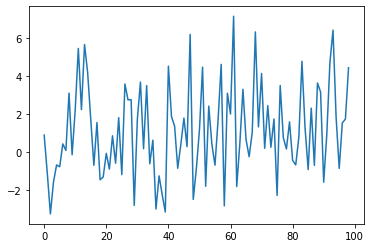

In [172]:
import matplotlib.pyplot as plt
plt.plot(sliding_window(rewards_list, window_size = 1000))